<a href="https://colab.research.google.com/github/shreyas1455/Telecom-inventory-management-system/blob/main/TIMS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 3.9841 - val_loss: 2.3982 - learning_rate: 0.0100
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7615 - val_loss: 2.3975 - learning_rate: 0.0100
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6109 - val_loss: 2.3775 - learning_rate: 0.0100
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7080 - val_loss: 2.4269 - learning_rate: 0.0100
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5983 - val_loss: 2.4149 - learning_rate: 0.0100
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6320 - val_loss: 2.4333 - learning_rate: 0.0100
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6226 - val_loss: 2.3827 - learning_rate: 0.0100
Epoch 8/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6488
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6496 - val_loss: 2.3954 - learning_rate: 0.010

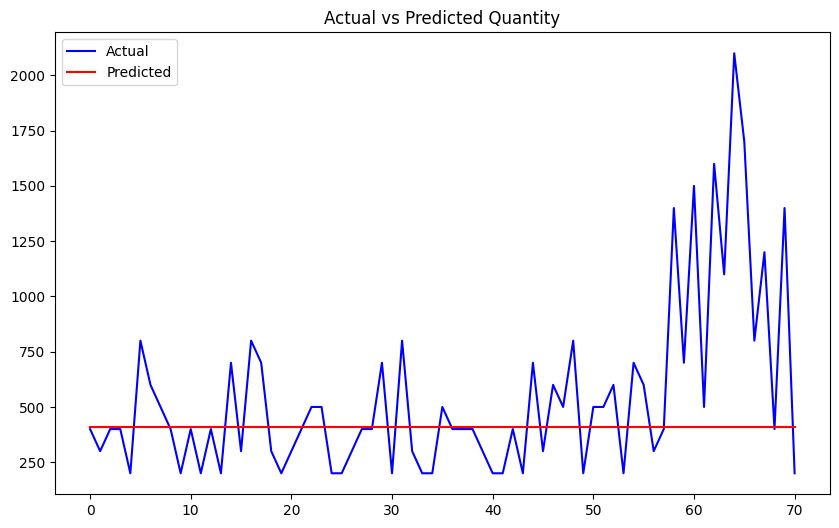

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


class Preprocess:
    def __init__(self, file_path, sheet_name):
        self.file_path = file_path
        self.sheet_name = sheet_name
        self.data = None
        self.time_series_data = None

    def load_data(self):
        """Load data from the specified Excel sheet."""
        excel_file = pd.ExcelFile(self.file_path)
        self.data = excel_file.parse(self.sheet_name)

    def clean_and_prepare(self):
        """Parse order dates, clean data, and prepare for time-series analysis."""
        self.data['Order Date'] = pd.to_datetime(self.data['Order Date'], errors='coerce')
        self.data = self.data.dropna(subset=['Order Date'])
        self.data = self.data.sort_values(by='Order Date')

    def aggregate_data(self):
        """Aggregate quantities by order date for time-series analysis."""
        time_series_data = self.data[['Order Date', 'Quantity']]
        self.time_series_data = time_series_data.groupby('Order Date').sum().reset_index()

    def get_time_series_data(self):
        """Return the prepared time-series data."""
        return self.time_series_data


class Forecast:
    def __init__(self, time_series_data):
        self.time_series_data = time_series_data
        self.model = None
        self.scaler = StandardScaler()  # Changed to StandardScaler

    def prepare_data(self, sequence_length=15):
        """Prepare data for LSTM/GRU forecasting."""
        quantity_scaled = self.scaler.fit_transform(self.time_series_data['Quantity'].values.reshape(-1, 1))

        X, y = [], []
        for i in range(len(quantity_scaled) - sequence_length):
            X.append(quantity_scaled[i:i + sequence_length])
            y.append(quantity_scaled[i + sequence_length])
        return np.array(X), np.array(y)

    def build_model(self, sequence_length, units=64, dropout_rate=0.3, l2_reg=0.1):
        """Build the GRU model."""
        self.model = Sequential([
            GRU(units, activation='relu', return_sequences=True, input_shape=(sequence_length, 1), kernel_regularizer=l2(l2_reg)),
            Dropout(dropout_rate),
            GRU(units, activation='relu', return_sequences=False, kernel_regularizer=l2(l2_reg)),
            Dropout(dropout_rate),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        optimizer = Adam(learning_rate=0.01)
        self.model.compile(optimizer=optimizer, loss='mse')

    def train_model(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
        """Train the model."""


        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

        self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size,
                       verbose=1, callbacks=[lr_scheduler])

    def evaluate_model(self, X_train, y_train, X_test, y_test):
        """Evaluate the model performance and calculate RMSE and MAPE."""
        train_loss = self.model.evaluate(X_train, y_train, verbose=0)
        test_loss = self.model.evaluate(X_test, y_test, verbose=0)

        y_train_pred = self.model.predict(X_train)
        y_test_pred = self.model.predict(X_test)

        # Inverse transform predictions and actual values
        y_train_pred = self.scaler.inverse_transform(y_train_pred)
        y_test_pred = self.scaler.inverse_transform(y_test_pred)
        y_train = self.scaler.inverse_transform(y_train.reshape(-1, 1))
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate RMSE for training and testing data
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Calculate R-squared for test data
        test_r2 = r2_score(y_test, y_test_pred)

        # Calculate MAPE
        def calculate_mape(y_true, y_pred):
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        train_mape = calculate_mape(y_train, y_train_pred)
        test_mape = calculate_mape(y_test, y_test_pred)

        print(f"Training Loss: {train_loss}")
        print(f"Testing Loss: {test_loss}")
        print(f"Training RMSE: {train_rmse:.2f}")
        print(f"Testing RMSE: {test_rmse:.2f}")
        print(f"Testing R-squared: {test_r2:.2f}")
        print(f"Training MAPE: {train_mape:.2f}%")
        print(f"Testing MAPE: {test_mape:.2f}%")

        # Visualize the predictions
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(len(y_test)), y_test, label='Actual', color='blue')
        plt.plot(np.arange(len(y_test_pred)), y_test_pred, label='Predicted', color='red')
        plt.title('Actual vs Predicted Quantity')
        plt.legend()
        plt.show()


# Preprocessing
preprocess = Preprocess('/content/Inventory_DataSet.xlsx', 'Product')
preprocess.load_data()
preprocess.clean_and_prepare()
preprocess.aggregate_data()
time_series_data = preprocess.get_time_series_data()

# Forecasting
forecast = Forecast(time_series_data)
sequence_length = 15  # Experiment with this value
X, y = forecast.prepare_data(sequence_length)

# Split into train and test sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build, train, and evaluate the model
forecast.build_model(sequence_length)
forecast.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=8)
forecast.evaluate_model(X_train, y_train, X_test, y_test)
